In [6]:
import matplotlib
import os
import sys
sys.path.append('..')
from er_simulator.wc_model import WCTaskSim
from er_simulator.functions import resample_signal
from er_simulator.synaptic_weights_matrices import normalize, generate_synaptic_weights_matrices
from er_simulator.read_utils import generate_sw_matrices_from_mat
from er_simulator.load_wc_params import load_wc_params
from er_simulator import functions
from er_simulator.boldIntegration import BWBoldModel
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import signal, stats, io

matplotlib.rcParams['font.family'] = 'Avenir'
matplotlib.rcParams['font.size'] = 10
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# all parameters will be download from yaml config file, check config before
wc_sim = WCTaskSim.from_config(config_file="../usage_examples/config_02_EVENT.yaml")
print(wc_sim.wc_params.keys())
print(wc_sim.bold_params.keys())

dict_keys(['dt', 'exc_ext', 'K_gl', 'inh_ext', 'a_exc', 'a_inh', 'c_excexc', 'c_excinh', 'c_inhexc', 'c_inhinh', 'mu_exc', 'mu_inh', 'tau_exc', 'tau_inh', 'tau_ou', 'sigma_ou', 'exc_ou_mean', 'inh_ou_mean', 'signalV', 'seed', 'exc_ou', 'inh_ou', 'exc_ext_baseline', 'inh_ext_baseline', 'exc_init', 'inh_init', 'lengthMat', 'Cmat'])
dict_keys(['k', 'gamma', 'tau', 'alpha', 'rho', 'fix', 'normalize_constant'])


In [30]:
%%time
wc_sim.generate_full_series(compute_bold=True)
output_task = wc_sim.output.copy()


CPU times: user 31.6 s, sys: 2.18 s, total: 33.8 s
Wall time: 32.7 s


Text(0.5, 1.0, 'Bold signal on unit pulse')

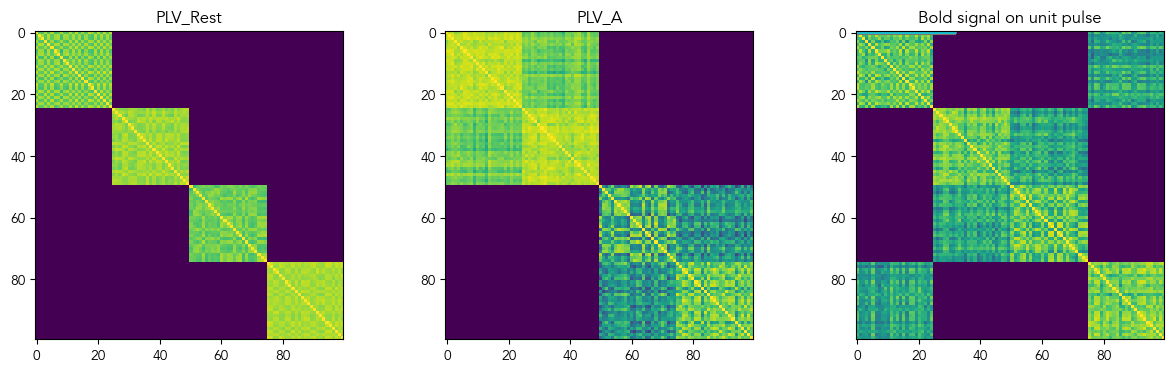

In [33]:
def compute_PLV(task_name, low_f=38, high_f=42):
    roi_idx1, roi_idx2 = np.triu_indices(wc_sim.num_regions, k=1)
    activity = wc_sim.get_task_block(task_name, 'mtime',  'syn_act',skip_time=0)
    nyquist = 1 / wc_sim.mTime / 2
    high_band = high_f / nyquist
    low_band = low_f / nyquist
    b1, a1 = signal.butter(4, [low_band, high_band], btype='bandpass')
    filtered_data = signal.filtfilt(b1, a1, activity)
    analytic_data = signal.hilbert(filtered_data)
    angles = np.angle(analytic_data)
    phase_diffs = np.zeros((len(roi_idx1), activity.shape[1]))
    for r in range(roi_idx1.shape[0]):
        phase_diffs[r, :] = angles[roi_idx1[r], :] - angles[roi_idx2[r], :]
    plv = abs(np.exp(1j * phase_diffs).mean(axis=1))
    plv_sym = np.eye(activity.shape[0])
    sym_synh = np.eye(activity.shape[0])
    sym_synh[roi_idx1, roi_idx2] = plv
    sym_synh = sym_synh+sym_synh.T
    return  sym_synh
fig, axs = plt.subplots(1, 3, figsize = (15,4))

title_list = ['PLV_Rest','PLV_A', 'PLV_B']
task_names = ["Rest","Task_A", "Task_B"]
for i in [0,1,2]:
    im = axs[i].imshow(compute_PLV(task_names[i]), cmap='viridis', vmin = 0.7, vmax=1);
    axs[i].set_title(title_list[i]);


Text(0.5, 1.0, 'Bold signal on unit pulse')

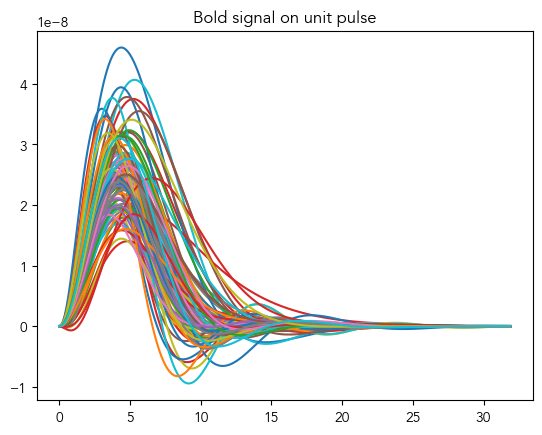

In [34]:
resampled_BOLD, time = wc_sim.boldModel.run_on_impulse()
plt.plot(time,resampled_BOLD.T); plt.title("Bold signal on unit pulse")

In [9]:
%%time
output_rest = wc_sim.generate_rest_series(compute_bold=True, rest_duration = 50)

CPU times: user 19.6 s, sys: 1.4 s, total: 21 s
Wall time: 19.9 s


Text(0.5, 1.0, 'Bold signal on unit pulse')

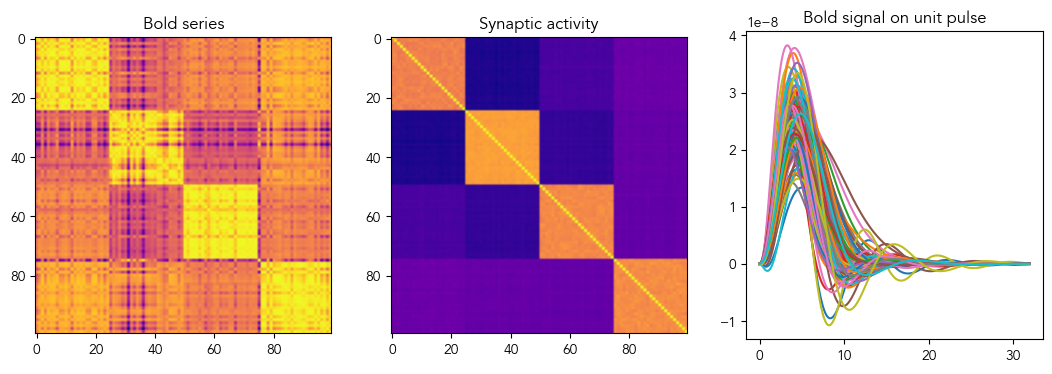

In [28]:
plt.figure(figsize = (13,4))
tune = int(8/ wc_sim.TR)
corr_series = np.corrcoef(output_rest['BOLD_TR'][:,tune:])
plt.subplot(131); plt.imshow(corr_series); plt.title("Bold series")
corr_series = np.corrcoef(output_rest['syn_act'])
plt.subplot(132); plt.imshow(corr_series); plt.title("Synaptic activity")
resampled_BOLD, time = wc_sim.boldModel.run_on_impulse()
plt.subplot(133); plt.plot(time,resampled_BOLD.T); plt.title("Bold signal on unit pulse")


In [19]:
#поставлени микротайм в 5 мс, чтобы потом можно было вытащить огибающую, если нужно меньше, то можно прямо здесь уменьшить и добавить
wc_sim.mTime


0.005

In [20]:
res_syn_act, res_time = resample_signal(output_rest['mtime'], output_rest["syn_act"], wc_sim.mTime, wc_sim.TR/16)

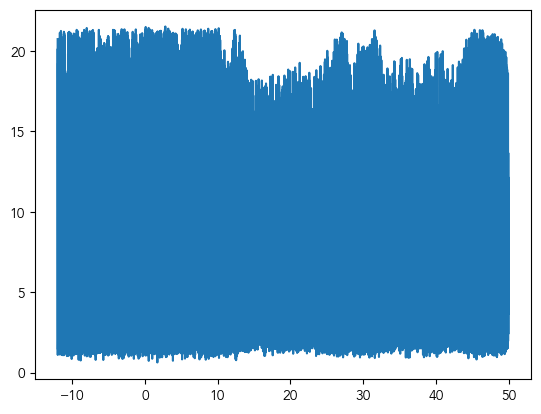

In [24]:
plt.plot(output_rest['mtime'], output_rest["syn_act"][0,:])

In [13]:
#посмотреть параметры болда
sub_bold = wc_sim.boldModel.get_parameters()
